The accuracy of the classifier on the test set is 0.994


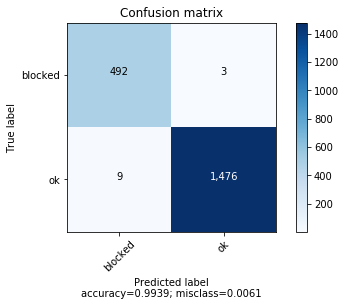

In [75]:
# Create a MultinomialNB object
clf = MultinomialNB()

# Fit the classifier
clf.fit(X_train_bow, y_train)

# Measure the accuracy
accuracy = clf.score(X_test_bow, y_test)
print("The accuracy of the classifier on the test set is %.3f" % accuracy)

predict = clf.predict(X_test_bow)

plot_confusion_matrix(confusion_matrix(y_test, predict), target_names=['blocked','ok'])

# Análise e detecção de SMS's bloqueados

In [167]:
# Importando bibliotecas básicas

import numpy as np                 # Algebra
import pandas as pd                # Dataframes
import urlextract                  # Manipulação de texto
import string                      # Manipulação de texto
import re                          # Manipulação de texto
import itertools
from collections import Counter    

    # Linguagem natural
import nltk                        
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords

    # Preprocessamento
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import CountVectorizer , TfidfVectorizer
from sklearn.pipeline import Pipeline , FeatureUnion
from sklearn.model_selection import train_test_split

    # Modelos básicos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix

    # Modelos de Deep Learning
'''
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping  
'''

    # Gráficos
import matplotlib.pyplot as plt    
%matplotlib inline
import seaborn as sns              

# Parâmetros de plotagem:
'''
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (8, 4)
sns.set(font_scale = 2)
''';


In [15]:
def plot_confusion_matrix(cm, target_names, title='Confusion matrix'):
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Blues')

    #plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
        
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [3]:
# Lendo os arquivos
train = pd.read_csv('train_data.csv', encoding='utf-8')          # Obs: utf-8 para reconhecer characters específicos
validation = pd.read_csv('validation_data.csv', encoding='utf-8')

In [4]:
# Dimensões
print("Dimensões dos dados de treino:", train.shape)
print("Dimensões dos dados de validação:", validation.shape)

Dimensões dos dados de treino: (6000, 2)
Dimensões dos dados de validação: (2000, 1)


In [5]:
# Distribuição dos dados no banco de treino:
train['LABEL'].value_counts()

ok         4500
blocked    1500
Name: LABEL, dtype: int64

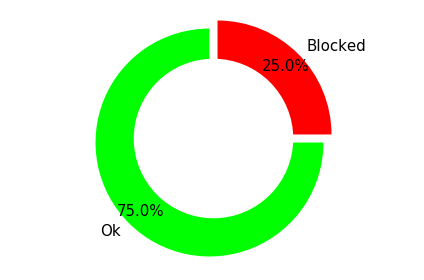

In [6]:
# Visualizando a distribuição:

labels = ['Ok', 'Blocked']
sizes = [train['LABEL'].value_counts()[0], train['LABEL'].value_counts()[1]]
colors = ['lime','red']
explode = (0.05,0.05)
 
plt.pie(sizes, colors = colors, labels=labels, 
        autopct='%1.1f%%', startangle=90, pctdistance=0.85, 
        explode = explode,
        textprops={'fontsize': 15})

centre_circle = plt.Circle((0,0),0.70,fc='white') # add circle
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()

In [7]:
# Verificando alguns exemplos de SMS's bloqueados
train[train.LABEL == 'blocked'].SMS.value_counts().head() 

Mercado BTC - Ha uma nova mensagem pendente. https://goo.gl/4mR8GX para ler.                                                                             3
Find My iPhone:Nova Localizacao disponivel,iPhone 6s 64GB Silver. Expira em 24h. Para visualizar acesse: https://supports-help.com/icloud                2
Alerta BB: Prezado Cliente, Evite o Cancelamento do seu SMS TOKEN sincronizando direto sem custo no Canal: goo.gl/KPPdWU Evite bloqueio da sua conta.    2
Your iOs ID has been blocked, an unknown device has just logged into iCloud, verify identity: https://apple.com.us-i.bid/?id=200                         2
Voce tem uma nova foto http://fotosms.xyz/c/d?i=R3c8s0XYa                                                                                                1
Name: SMS, dtype: int64

In [8]:
# Verificando alguns exemplos de SMS's ok
train[train.LABEL == 'ok'].SMS.value_counts().head() 

131.221.110.19 DNS-SECUNDARIO                                                                                                          13
[SulAmerica] Corretor: YAMAHA MOTOR CORR DE SEGS LTDA - backoffice.corretora@yamaha-motor.com.br - (11) 2431-6840 / (11) 98685-1180     9
PROBLEM: FW S.Luis queda de rede 170.238.12.82\r\r\nAlert:High                                                                          9
Zabbix GW-SP-02:: BGP Session from LANAUTILUS (149.3.181.98, AS 6762) with IDLE (1) DOWN\r\r\nbgpSession[LANAUTILUS]                    8
RECURSO INOPERANTE - ITECT-ATRIUM-FWL 138.122.67.6                                                                                      6
Name: SMS, dtype: int64

In [9]:
# Verificando alguns exemplos de SMS's da validação
validation['SMS'].value_counts().head()

Zabbix PE-BARAO-01:: BGP Session from LYRA NETWORK  (179.191.79.98, AS 264249) with IDLE (1) DOWN\r\r\nbgpSession[LYRA]        7
Zabbix PE-BARAO-01:: BGP Session from CD One (179.191.79.26, AS 52818) with IDLE (1) DOWN\r\r\nbgpSession[CD1]                 6
Zabbix PE-BARAO-01:: BGP Session from 55 Telecom (179.191.79.54, AS 268232) with ACTIVE (3) DOWN\r\r\nbgpSession[55TELECOM]    5
Zabbix PE-BARAO-01:: BGP Session from BTG (179.191.79.50,AS 52798) with IDLE (1) DOWN\r\r\nbgpSession[BTG]                     5
Sent from your Twilio trial account - Entrou em sua conta 179.214.240.103                                                      5
Name: SMS, dtype: int64

# Baseline Model

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train['SMS'], train['LABEL'], 
                                                    test_size=0.33, random_state=42, stratify=train['LABEL'])

In [11]:
print("Dimensões dos dados de treino:", X_train.shape)
print("Dimensões dos dados de teste:", X_test.shape)

Dimensões dos dados de treino: (4020,)
Dimensões dos dados de teste: (1980,)


In [12]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords.words('portuguese'))

# Fit and transform X_train
X_train_bow = vectorizer.fit_transform(X_train)

# Transform X_test
X_test_bow = vectorizer.transform(X_test)

# Print shape of X_train_bow and X_test_bow
print(X_train_bow.shape)
print(X_test_bow.shape)

(4020, 5861)
(1980, 5861)


In [13]:
# Create a simple model
clf = KNeighborsClassifier()

# Fit the classifier
clf.fit(X_train_bow, y_train)

# Predict the test set
predict = clf.predict(X_test_bow)

print(classification_report(y_test, predict))

              precision    recall  f1-score   support

     blocked       0.95      0.98      0.97       495
          ok       0.99      0.98      0.99      1485

   micro avg       0.98      0.98      0.98      1980
   macro avg       0.97      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



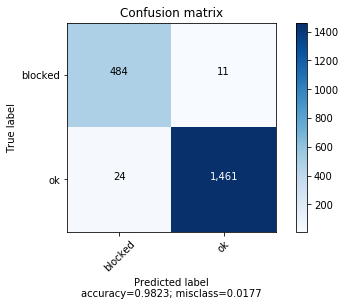

In [16]:
# Matrix de confusão
plot_confusion_matrix(confusion_matrix(y_test, predict), target_names=['blocked','ok'])

## Baseline Model 2

In [169]:
def process(text):
    # lowercase it
    text = text.lower()
    # remove punctuation
    text = ''.join([t for t in text if t not in string.punctuation])
    # remove stopwords
    text = [t for t in text.split() if t not in stopwords.words('portuguese')]
    # stemming (Não aplicado)
    
    return text

# Create a CountVectorizer object
vectorizer = TfidfVectorizer(analyzer=process)

# Fit and transform X_train
X_train_bow = vectorizer.fit_transform(X_train)

# Transform X_test
X_test_bow = vectorizer.transform(X_test)

# Print shape of X_train_bow and X_test_bow
print(X_train_bow.shape)
print(X_test_bow.shape)

(4020, 8505)
(1980, 8505)


In [173]:
# Create a simple model
clf = MultinomialNB()

# Fit the classifier
clf.fit(X_train_bow, y_train)

# Predict the test set
predict = clf.predict(X_test_bow)

print(classification_report(y_test, predict))

              precision    recall  f1-score   support

     blocked       0.99      0.95      0.97       495
          ok       0.98      1.00      0.99      1485

   micro avg       0.98      0.98      0.98      1980
   macro avg       0.99      0.97      0.98      1980
weighted avg       0.98      0.98      0.98      1980



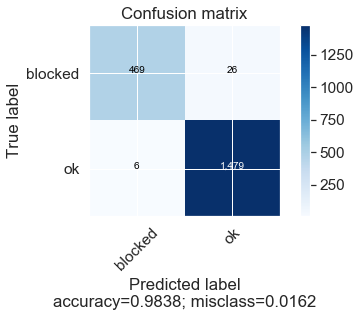

In [174]:
# Matrix de confusão
plot_confusion_matrix(confusion_matrix(y_test, predict), target_names=['blocked','ok']);

# Feature Engineering

In [17]:
# adicionando uma coluna com o 'comprimento' de cada texto

train['len'] = train['SMS'].str.len()
validation['len'] = validation['SMS'].str.len()

In [18]:
# adicionando uma coluna com o número de palavras de cada texto

# Function that returns number of words in a string
def count_words(sms):
    words = sms.split()
    return len(words)

train['word_count'] = train['SMS'].apply(count_words)
validation['word_count'] = validation['SMS'].apply(count_words)

In [19]:
# adicionando uma coluna com o número de hashtags

# Function that returns number of hashtags in a string
def count_hash(sms):
    words = sms.split()
    hashs = [word for word in words if word.startswith('@')]
    return(len(hashs))

train['hash_count'] = train['SMS'].apply(count_hash)
validation['hash_count'] = validation['SMS'].apply(count_hash)

In [20]:
# Criando uma coluna verificando se existe alguma URL
url_extractor = urlextract.URLExtract()

train['url'] = 0
for i in np.arange(0,len(train.SMS)):
    train.loc[i,'url'] = 1 if len(url_extractor.find_urls(train.loc[i,'SMS'])) > 0 else 0

validation['url'] = 0
for i in np.arange(0,len(validation.SMS)):
    validation.loc[i,'url'] = 1 if len(url_extractor.find_urls(validation.loc[i,'SMS'])) > 0 else 0


In [21]:
# Criando uma coluna verificando se existe algum número

train['number'] = 0
for i in np.arange(0,len(train.SMS)):
    train.loc[i,'number'] = 1 if len(re.findall(r'\d+(?:\.\d*(?:[eE]\d+))?', train.loc[i,'SMS'])) > 0 else 0
    
validation['number'] = 0
for i in np.arange(0,len(validation.SMS)):
    validation.loc[i,'number'] = 1 if len(re.findall(r'\d+(?:\.\d*(?:[eE]\d+))?', validation.loc[i,'SMS'])) > 0 else 0    

In [22]:
# Criando uma coluna verificando se existe a palavra senha

train['senha'] = 0
for i in np.arange(0,len(train.SMS)):
    train.loc[i,'senha'] = 1 if len(re.findall(r'senha', train.loc[i,'SMS'].lower())) > 0 else 0
    
validation['senha'] = 0
for i in np.arange(0,len(validation.SMS)):
    validation.loc[i,'senha'] = 1 if len(re.findall(r'senha', train.loc[i,'SMS'].lower())) > 0 else 0


# EDA

In [79]:
# Verificando qual das features criadas que apresentam maior
train.groupby('LABEL').mean().round(4)

,len,word_count,hash_count,url,number,senha
LABEL,,,,,,
blocked,97.0607,10.7200,0.0000,0.9873,0.8773,0.6327
ok,105.3029,13.7687,0.0018,0.1222,0.9913,0.0093


* Observa-se que 98.7% dos SMS's bloqueados apresentam uma URL, contra 12,22% dos SMS's ok
* Observa-se que 63.3% dos SMS's bloqueados apresentam a palavra "senha", contra menos de 1% dos SMS's ok
* Das demais features criadas, não nota-se num primeiro momento uma grande diferença


In [81]:
# Criando uma variável de saída binária
le = LabelEncoder()
le.fit(train['LABEL'])
train['y'] = le.transform(train['LABEL'])

In [84]:
# Verificando a correlação de cada feature criada
train.corr()

,len,word_count,hash_count,url,number,senha,y
len,1.000000,0.934411,0.010495,0.119718,-0.004540,-0.056426,0.091062
word_count,0.934411,1.000000,-0.004614,-0.026351,0.030804,-0.189138,0.220362
hash_count,0.010495,-0.004614,1.000000,-0.026138,0.007179,-0.016253,0.021096
url,0.119718,-0.026351,-0.026138,1.000000,-0.189008,0.599979,-0.791641
number,-0.004540,0.030804,0.007179,-0.189008,1.000000,-0.071578,0.260947
senha,-0.056426,-0.189138,-0.016253,0.599979,-0.071578,1.000000,-0.726875
y,0.091062,0.220362,0.021096,-0.791641,0.260947,-0.726875,1.000000


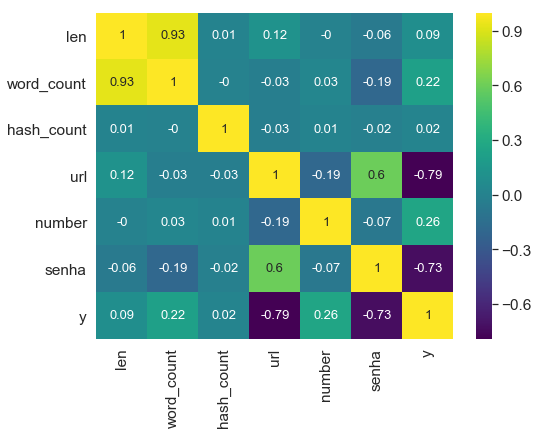

In [114]:
# Plotando um mapa de calor das correlações
plt.figure(figsize=(8,6))
sns.set(font_scale=1.4)
sns.heatmap(train.corr().round(2), annot=True, cmap='viridis', annot_kws={"size": 13});

### As maiores correlações da variável de saída são:
* URL: 79%
* senha: 73%

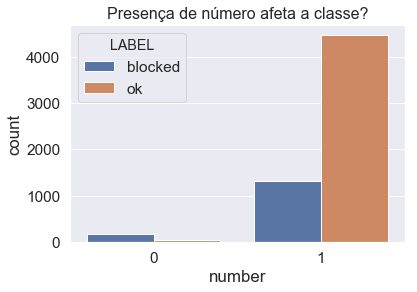

In [144]:
# Relação entre url e labels

sns.countplot(x = train['number'], hue=train['LABEL'])
plt.title('Presença de número afeta a classe?', fontsize = 16)
plt.show()

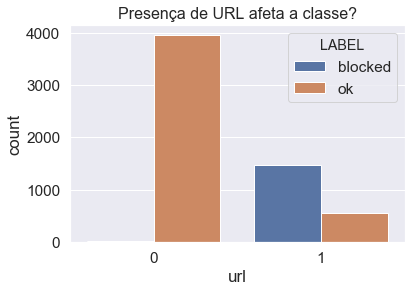

In [143]:
# Relação entre url e labels

sns.countplot(x = train['url'], hue=train['LABEL'])
plt.title('Presença de URL afeta a classe?', fontsize = 16)
plt.show()

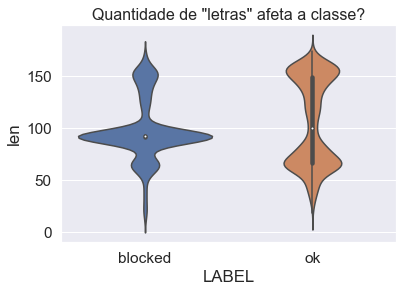

In [145]:
# Relação entre comprimento e classificação

sns.violinplot(x = train['LABEL'], y = train['len'])
plt.title('Quantidade de "letras" afeta a classe?', fontsize = 16)
plt.show()

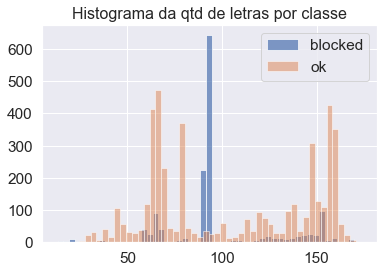

In [147]:
plt.hist(train[train['LABEL']=='blocked']['len']
            ,50, alpha=0.7, label='blocked')
plt.hist(train[train['LABEL']=='ok']['len']
            ,50, alpha=0.5, label='ok')
plt.title('Histograma da qtd de letras por classe', fontsize = 16)
plt.legend()
plt.show()

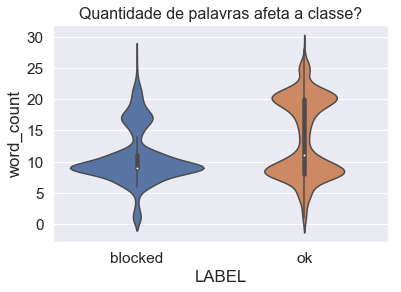

In [150]:
# Relação entre word_count e classificação

sns.violinplot(x = train['LABEL'], y = train['word_count'])
plt.title('Quantidade de palavras afeta a classe?', fontsize = 16)
plt.show();

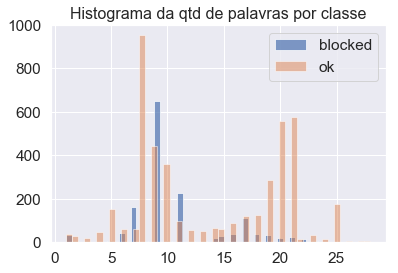

In [149]:
plt.hist(train[train['LABEL']=='blocked']['word_count']
            ,50, alpha=0.7, label='blocked')
plt.hist(train[train['LABEL']=='ok']['word_count']
            ,50, alpha=0.5, label='ok')
plt.title('Histograma da qtd de palavras por classe', fontsize = 16)
plt.legend()
plt.show()

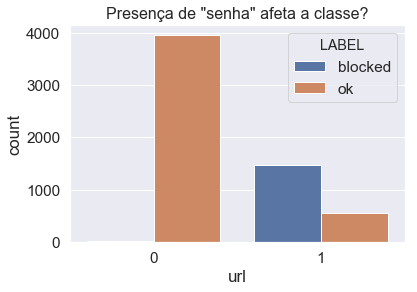

In [151]:
# Relação entre senha e labels

sns.countplot(x = train['url'], hue=train['LABEL'])
plt.title('Presença de "senha" afeta a classe?', fontsize = 16)
plt.show()

In [152]:
# Criando uma função para remover pontuações e as stopwords

def remove_punctuation_and_stopwords(sms):
    
    sms_new = [ch for ch in sms if ch not in string.punctuation]
    sms_new = "".join(sms_new).split()
    sms_new = [word.lower() for word in sms_new if word.lower() not in stopwords.words("portuguese")]

    return sms_new

train['SMS_new'] = train['SMS'].apply(remove_punctuation_and_stopwords)

In [158]:
# Usando a função criada para criar uma lista de palavras únicas e suas contagems para cada classificação
words_ok = train[train['LABEL']=='ok']['SMS_new'].tolist()
words_block = train[train['LABEL']=='blocked']['SMS_new'].tolist()

# diminuindo uma dimensão das listas
list_words_ok = []
for sublist in words_ok:
    for item in sublist:
        list_words_ok.append(item)
list_words_block = []
for sublist in words_block:
    for item in sublist:
        list_words_block.append(item)
        
# Selecionando as 30 mais frequentes de cada categoria
list_words_ok  = Counter(list_words_ok)
list_words_block = Counter(list_words_block)
top30_ok  = pd.DataFrame(list_words_ok.most_common(30),  columns=['word', 'count'])
top30_block = pd.DataFrame(list_words_block.most_common(30), columns=['word', 'count'])

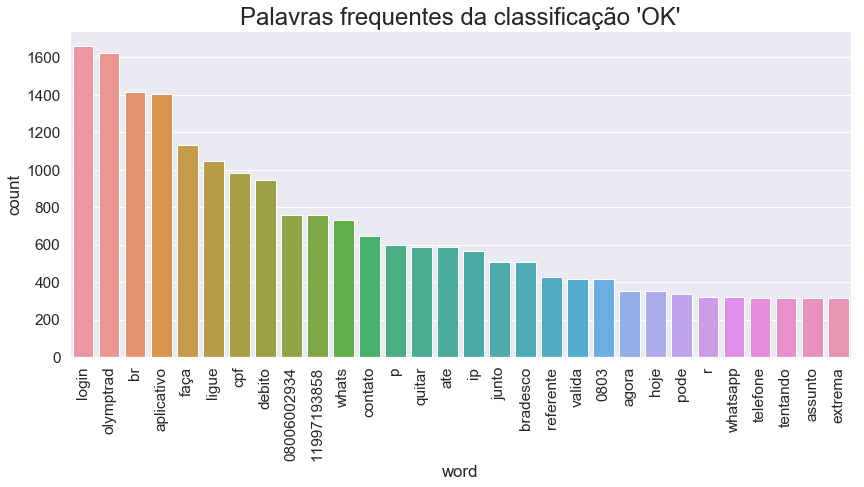

In [164]:
# Plotando os resultados
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x='word', y='count', 
            data=top30_ok, ax=ax)
plt.title("Palavras frequentes da classificação 'OK'", fontsize = 24)
plt.xticks(rotation='vertical');

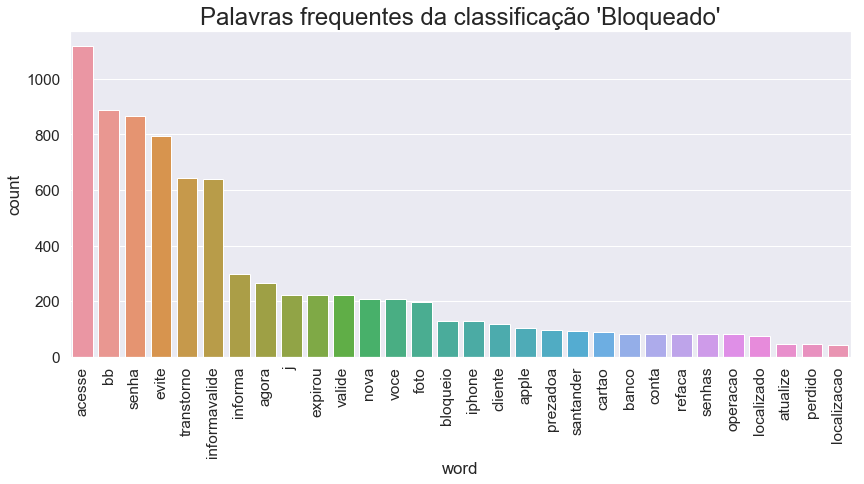

In [165]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.barplot(x='word', y='count', 
            data=top30_block, ax=ax)
plt.title("Palavras frequentes da classificação 'Bloqueado'", fontsize = 24)
plt.xticks(rotation='vertical');

# Testando um modelo com as novas features

In [177]:
# Create a CountVectorizer object
vectorizer = CountVectorizer(lowercase=True, stop_words=stopwords.words('portuguese'))

# Fit and transform X_train
X_bow = vectorizer.fit_transform(train.SMS)
X_bow_data=pd.DataFrame(X_bow.toarray())

In [207]:
final_data=pd.concat([X_bow_data,
                     train['len'], train['word_count'], train['url'], train['number'], train['senha'], 
                     ], axis=1)
final_data.head()

,0,1,2,3,4,5,6,7,8,9,...,7511,7512,7513,7514,7515,len,word_count,url,number,senha
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,142,24,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,52,2,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,47,2,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,109,14,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,47,1,1,1,0


In [208]:
X_train, X_test, y_train, y_test = train_test_split(final_data, train['y'], 
                                                    test_size=0.33, random_state=42, stratify=train['LABEL'])

In [209]:
# Create a simple model
clf = RandomForestClassifier()

# Fit the classifier
clf.fit(X_train, y_train)

# Predict the test set
predict = clf.predict(X_test)

print(classification_report(y_test, predict))

C:\Users\rodri\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      0.99       495
           1       1.00      1.00      1.00      1485

   micro avg       1.00      1.00      1.00      1980
   macro avg       0.99      1.00      1.00      1980
weighted avg       1.00      1.00      1.00      1980



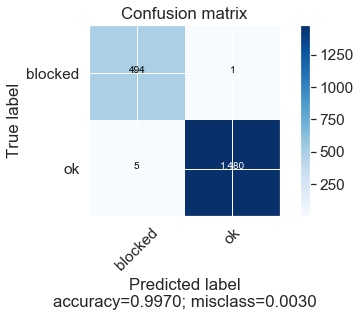

In [210]:
plot_confusion_matrix(confusion_matrix(y_test, predict), target_names=['blocked','ok'])

In [196]:
final_data=pd.concat([
                     train['len'], train['word_count'], train['url'], train['number'], train['senha'], 
                     ], axis=1)
final_data.head()

,len,word_count,url,number,senha
0,142,24,0,1,0
1,52,2,1,1,0
2,47,2,1,1,0
3,109,14,1,0,0
4,47,1,1,1,0


In [200]:
X_train, X_test, y_train, y_test = train_test_split(final_data, train['y'], 
                                                    test_size=0.33, random_state=42, stratify=train['LABEL'])

# Create a simple model
clf = RandomForestClassifier()

# Fit the classifier
clf.fit(X_train, y_train)

# Predict the test set
predict = clf.predict(X_test)

print(classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       495
           1       0.99      0.99      0.99      1485

   micro avg       0.98      0.98      0.98      1980
   macro avg       0.98      0.98      0.98      1980
weighted avg       0.98      0.98      0.98      1980



C:\Users\rodri\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


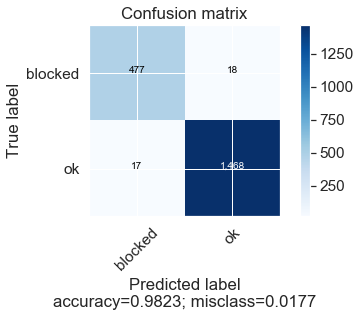

In [201]:
plot_confusion_matrix(confusion_matrix(y_test, predict), target_names=['blocked','ok'])